In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from spectraltools import Spectral
from tensorflow import keras
from tensorflow.keras.datasets import mnist

In [2]:
# SPECTRAL NN MODEL

def spectral_model():
    mod = tf.keras.Sequential()
    mod.add(tf.keras.Input(shape=(x_train.shape[1])))
    mod.add(Spectral(units=100,
                     is_base_trainable=True,
                     is_diag_end_trainable=False,
                     is_diag_start_trainable=True,
                     activation='tanh',
                     use_bias=True,
                     diag_end_initializer='Zeros',
                     diag_start_initializer='Ones',
                     diag_regularizer=tf.keras.regularizers.L2(l2=1e-6),
                     base_regularizer=tf.keras.regularizers.L2(l2=1e-2)))
    mod.add(tf.keras.layers.BatchNormalization())
    mod.add(tf.keras.layers.Dropout(0.2))
    mod.add(Spectral(units=100,
                     is_base_trainable=True,
                     is_diag_end_trainable=False,
                     is_diag_start_trainable=True,
                     activation='relu',
                     use_bias=True,
                     diag_end_initializer='Zeros',
                     diag_start_initializer='Ones'))
    mod.add(Spectral(units=50,
                     is_base_trainable=True,
                     is_diag_end_trainable=False,
                     is_diag_start_trainable=True,
                     activation='relu',
                     use_bias=True,
                     diag_end_initializer='Zeros',
                     diag_start_initializer='Ones'))
    mod.add(Spectral(2,
                     is_base_trainable=True,
                     is_diag_end_trainable=False,
                     is_diag_start_trainable=True,
                     activation='softmax',
                     use_bias=True,
                     diag_end_initializer='Zeros',
                     diag_start_initializer='Ones'))
    return mod

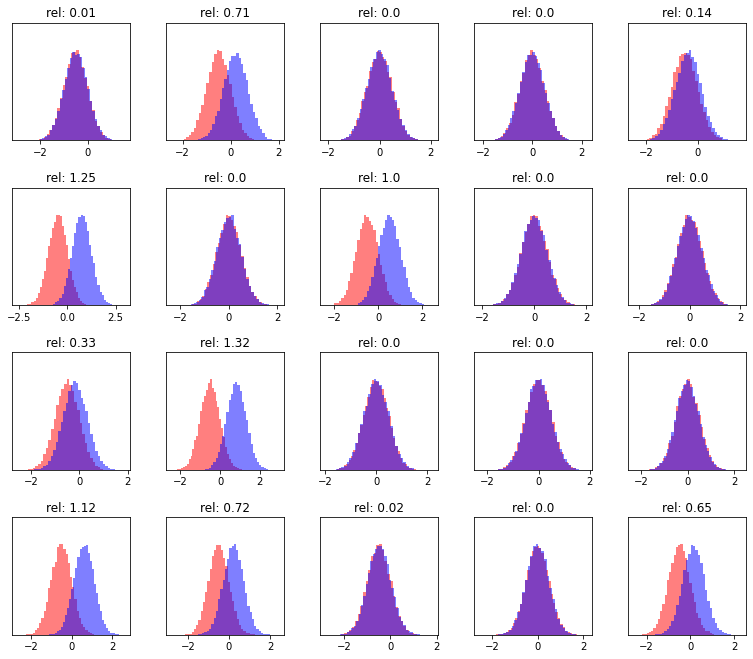

In [3]:
#GAUSSIAN HANDMADE DATASET

n_feature = 20
n_relevant = 11
n_examples = 60000
n_classes = 2
sigma = 0.5

perm = np.random.permutation(np.arange(n_feature))
rel_indexes = perm[:n_relevant]
not_rel_indexes = perm[n_relevant:]

relative_relevance = np.random.uniform(0.,1.4, n_feature)
relative_relevance[not_rel_indexes] = 0

x = np.zeros((n_examples, n_feature))
y = np.random.randint(0,n_classes, n_examples)

mu_array = np.zeros((n_feature, n_classes))

i=0
for f in rel_indexes:
    mu_array[f,:] =np.arange(n_classes)*(relative_relevance[f])  - np.mean(np.arange(n_classes))  # np.random.uniform(-2,2, n_classes)*3

for f in range(n_feature):
    for c in range(n_classes):
        x[y==c,f]= np.random.normal(mu_array[f,c], sigma, len(y[y==c]))

cl0 = x[y==0]
cl1 = x[y==1]

#define train and test set
x_train, x_test = x[:int(x.shape[0]*0.8)], x[int(x.shape[0]*0.8):]
y_train, y_test = y[:int(y.shape[0]*0.8)], y[int(y.shape[0]*0.8):]


#plot distributions 
cl0 = x[y == 0]
cl1 = x[y == 1]
maxs = []
for i in range(n_feature):
    maxs.append(max(list(np.histogram(cl0[:, i], 40,density=True)[0]) + list(np.histogram(cl1[:, i], 40, density=True)[0])))


fig, ax = plt.subplots(4, 5, figsize=(12, 10))
i = 0
for r in range(4):
    for c in range(5):
        if i < x.shape[1]:
            ax[r, c].hist(cl0[:, i], 40, color='r', alpha=0.5, density=True)
            ax[r, c].hist(cl1[:, i], 40, color='b', alpha=0.5, density=True)
            ax[r, c].tick_params(left=False)  # remove the ticks
            ax[r, c].set_yticklabels([])
            ax[r, c].set_ylim([0, 1.3 * maxs[i]])
            ax[r,c].set_title('rel: '+str(np.around(relative_relevance[i],2)))
        i += 1
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()




In [4]:
# Spectral NN training

n_experiments=2 # we used 10
list_results=[]
for i in range(n_experiments):
    mod = spectral_model()
    mod.compile(
        optimizer=tf.keras.optimizers.Adam(0.01),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics='accuracy',
    )
    hist = mod.fit(x_train, y_train,
                   batch_size=500,
                   epochs=100, # we used 1000
                   validation_split=0.1,
                   verbose=1)

    eig_start = Spectral.return_diag(mod.layers[0])
    base_start = mod.layers[0].base
    norma = tf.linalg.norm(base_start, ord=2, axis=1)
    eig_norm = (eig_start * norma)
    list_results.append(eig_norm)

Epoch 1/100
87/87 [==============================] - 2s 9ms/step - loss: 0.1081 - accuracy: 0.9869 - val_loss: 0.1322 - val_accuracy: 0.9925
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0245 - accuracy: 0.9943 - val_loss: 0.0493 - val_accuracy: 0.9954
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0214 - accuracy: 0.9946 - val_loss: 0.0395 - val_accuracy: 0.9937
Epoch 4/100
87/87 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.0269 - val_accuracy: 0.9923
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0206 - accuracy: 0.9947 - val_loss: 0.0176 - val_accuracy: 0.9973
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.0168 - val_accuracy: 0.9969
Epoch 7/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0182 - accuracy: 0.9952 - val_loss: 0.0172 - val_accuracy: 0.9958
Epoch 8/100
8

Epoch 59/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0154 - accuracy: 0.9954 - val_loss: 0.0249 - val_accuracy: 0.9942
Epoch 60/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0159 - accuracy: 0.9952 - val_loss: 0.0238 - val_accuracy: 0.9940
Epoch 61/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0156 - accuracy: 0.9956 - val_loss: 0.0204 - val_accuracy: 0.9940
Epoch 62/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.0141 - val_accuracy: 0.9971
Epoch 63/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.0168 - val_accuracy: 0.9960
Epoch 64/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0158 - accuracy: 0.9954 - val_loss: 0.0167 - val_accuracy: 0.9958
Epoch 65/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.0144 - val_accuracy: 0.9967
Epoch 

Epoch 17/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0183 - accuracy: 0.9950 - val_loss: 0.0177 - val_accuracy: 0.9969
Epoch 18/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0169 - accuracy: 0.9953 - val_loss: 0.0154 - val_accuracy: 0.9975
Epoch 19/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0162 - accuracy: 0.9951 - val_loss: 0.0156 - val_accuracy: 0.9958
Epoch 20/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0175 - accuracy: 0.9953 - val_loss: 0.0203 - val_accuracy: 0.9958
Epoch 21/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0162 - accuracy: 0.9950 - val_loss: 0.0196 - val_accuracy: 0.9954
Epoch 22/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0175 - accuracy: 0.9953 - val_loss: 0.0164 - val_accuracy: 0.9952
Epoch 23/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0159 - accuracy: 0.9953 - val_loss: 0.0144 - val_accuracy: 0.9971
Epoch 

Epoch 75/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0160 - accuracy: 0.9952 - val_loss: 0.0162 - val_accuracy: 0.9960
Epoch 76/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0145 - val_accuracy: 0.9971
Epoch 77/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0157 - accuracy: 0.9957 - val_loss: 0.0152 - val_accuracy: 0.9960
Epoch 78/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0156 - accuracy: 0.9956 - val_loss: 0.0146 - val_accuracy: 0.9962
Epoch 79/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0158 - accuracy: 0.9954 - val_loss: 0.0149 - val_accuracy: 0.9969
Epoch 80/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0155 - accuracy: 0.9956 - val_loss: 0.0150 - val_accuracy: 0.9965
Epoch 81/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0158 - accuracy: 0.9950 - val_loss: 0.0161 - val_accuracy: 0.9960
Epoch 

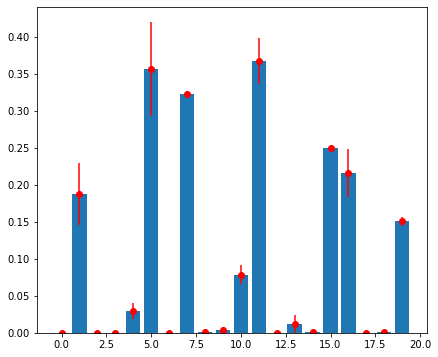

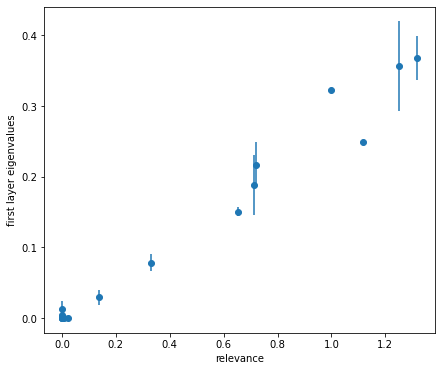

In [9]:
#Plotting the results
arr = np.zeros((len(list_results), list_results[0].shape[0]))
for i in range(len(list_results)):
    arr[i,:] = np.abs(list_results[i].numpy())
mean = arr.mean(axis=0)
std = arr.std(axis=0)

plt.figure(figsize=(7,6))
plt.bar(np.arange(n_feature),mean)
plt.errorbar(np.arange(n_feature), mean, yerr=std, marker='o', linestyle='none', color='r')
plt.show()

plt.figure(figsize=(7,6))
plt.errorbar(relative_relevance, mean, yerr=std, marker='o', linestyle='none')
plt.xlabel('relevance')
plt.ylabel('first layer eigenvalues')
plt.show()